In [5]:
import pandas as pd
import numpy as np

trading_instrument = 'al'
dir_data_path ='RESULT_ALL_new'
dir_path = os.path.join(dir_data_path,trading_instrument)
info_file_path =  os.path.join(dir_path,trading_instrument + "_info.csv")

info_data = pd.read_csv(info_file_path, index_col=[0])
# audata = pd.read_csv("RESULT_ALL_new/al/al2103_al2104_final.csv", index_col=[0], parse_dates=[0])
# audata['trading_date'] = pd.to_datetime(audata['trading_date'])
info_data['change_date'] = pd.to_datetime(info_data['change_date'])
info_data

,change_date,a_id,b_id
0,2020-05-26,al2007,al2008
1,2020-06-23,al2008,al2009
2,2020-07-28,al2009,al2010
3,2020-08-27,al2010,al2011
4,2020-09-28,al2011,al2012
5,2020-10-29,al2012,al2101
6,2020-11-27,al2101,al2102
7,2020-12-24,al2102,al2103
8,2021-01-18,al2103,al2104
9,2021-02-22,al2104,al2105


In [49]:
def get_trading_data(trading_date_now, df_all, history_days):
    res_finding = False
    res_today_df = pd.DataFrame()
    res_history_df = pd.DataFrame()  
    #1.先找出今天数据
    today_data = df_all[(df_all['trading_date'] >= trading_date_now) & (df_all['trading_date'] < (trading_date_now + pd.Timedelta("1 day")))]
    if len(today_data) < 10:
        return res_finding,res_today_df,res_history_df

    res_today_df = today_data
    #2.取出历史数据
    history_date = trading_date_now
    history_data_count = 0
          
    for i in range(0,30):
        history_date = history_date - pd.Timedelta("1 day")
        if history_data_count < history_days:
            history_data = df_all[(df_all['trading_date'] >= history_date) & (df_all['trading_date'] < (history_date + pd.Timedelta("1 day")))]
            if len(history_data) > 10:
                history_data_count += 1
                res_history_df = pd.concat([res_history_df,history_data])
    if history_data_count == history_days:
        res_finding = True
    return res_finding,res_today_df,res_history_df


import datetime
import statsmodels.api as sm
start_date = datetime.datetime(2021, 1, 1)
end_date = datetime.datetime(2021, 5, 1)
trading_date = start_date

direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []
trading_date_in = ""

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 1
tick_size = 5
profit = 3 * tick_size
K = 0
beta = 0
up_threshold = 0

current_info_index = -1
holding = False
data_all = pd.DataFrame()
test_data = pd.DataFrame()


#生成交易信号阈值
up_threshold = 20
down_threshold = - up_threshold

up_threshold_save = up_threshold
down_threshold_save = down_threshold

#生成止损信号阈值
up_threshold_stop = 60#up_threshold * 10
down_threshold_stop = -up_threshold_stop

up_threshold_stop_save = up_threshold_stop
down_threshold_stop_save = down_threshold_stop
#生成最大亏损信号阈值
biggest_lost = -150
#生成平仓信号阈值
up_close_threshold = up_threshold - profit #up_threshold - 8 * tick_size
# down_close_threshold = down_threshold + 3 * tick_size
down_close_threshold = -up_close_threshold

while trading_date <= end_date:
    trading_date = trading_date + pd.Timedelta("1 day")
    # print(trading_date)
    #1.检查需要的数据
    for i in range(0,len(info_data) - 1):
        if trading_date >= info_data.change_date[i] and trading_date < info_data.change_date[i + 1]:
            if holding == False and current_info_index != i:
                current_info_index = i
                data_all_path = os.path.join(dir_path,info_data.a_id[i] + "_" + info_data.b_id[i] + "_final.csv")
                data_all = pd.read_csv(data_all_path, index_col=[0], parse_dates=[0])
                data_all['trading_date'] = pd.to_datetime(data_all['trading_date'])
                print(data_all_path)
            elif holding == True and current_info_index != i:
                if trading_date > (info_data.change_date[i] + pd.Timedelta("7 day")):
                    holding = False
                    if direction == 'a-b':
                        single_ret = (Spread2_ask[-1] - enter_record[-1][0])
                    else:
                        single_ret = (enter_record[-1][0] - Spread2_bid[-1])
                    
                    if trading_date_in == test_data.trading_date[-10]:
                        single_cost = cost_rate * (test_data.last_A[-10] + test_data.last_B[-10])
                    else:
                        single_cost = cost_rate * (test_data.last_A[-10] + test_data.last_B[-10]) * 2 
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append((Spread2_ask[i], ask_price, test_data.index[i],single_ret,single_cost))
                    print('还有持仓，强平',Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
    #有数据再处理
    if len(data_all) > 10:
        res_finding, test_data_temp, df_history_temp = get_trading_data(trading_date,data_all,delta_days)
        if res_finding == True:
            test_data = test_data_temp
            df_history = df_history_temp
            #使用数据的成交价拟合beta
            model = sm.OLS(df_history.last_A, df_history.last_B).fit()
            beta = model.params['last_B']
            eps = df_history.last_A - df_history.last_B * beta #生成拟合后数据

            #根据beta生产对手价的ask和bid序列
            eps2_ask = test_data.bid_A - test_data.ask_B * beta
            eps2_bid = test_data.ask_A - test_data.bid_B * beta
            #生成实际的成交的ask和bid价格（由于实际交易都是1:1）
            Spread2_ask = test_data.bid_A - test_data.ask_B
            Spread2_bid = test_data.ask_A - test_data.bid_B

            print(" ")
            print('test_day:',trading_date)
            print(model.params)

            #进入交易
            

            print('beta:',beta)
            print('阈值：',up_threshold)
            print('止损点：',up_threshold_stop)

            #遍历数据判断交易
            for i, v in enumerate(eps2_ask.values):
                #交易时间点判断:去除开盘前10分钟和收盘前十分钟
                start_time1 = datetime.time(21,10,0) #夜盘开盘
                start_time2 = datetime.time(9,10,0) #早上开盘

                end_time1 = datetime.time(0,50,0) #夜盘收盘
                end_time2 = datetime.time(14,50,0) #下午收盘
                #判断是否在我们规定交易时段
                if (eps2_ask.index[i].time() > start_time1 or eps2_ask.index[i].time() < end_time1) or \
                    (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

                    ask_price = eps2_ask[i] #获取价格
                    bid_price = eps2_bid[i]
                    if not holding:
                        # 判断进场条件
                        if ask_price > up_threshold:#and stop_event != 'up_stop':
                            holding = True
                            stop_event = "none"
                            direction = 'b-a'
                            trading_date_in = test_data.trading_date[i]
                            print(test_data.index[i],'b-a进场', Spread2_ask[i], ask_price,'--',len(enter_record))
                            #记录进出场信息
                            enter_record.append((Spread2_ask[i], ask_price,test_data.index[i],direction))
                        elif bid_price < down_threshold :#and stop_event != 'down_stop':
                            holding = True
                            stop_event = "none"
                            direction = 'a-b'
                            trading_date_in = test_data.trading_date[i]
                            print(test_data.index[i],'a-b进场', Spread2_bid[i], bid_price,'--',len(enter_record))
                            enter_record.append((Spread2_bid[i], bid_price,test_data.index[i],direction))
                            
                    elif holding:
                        # 判断离场条件
                        if direction == 'a-b' and ask_price > down_close_threshold:
                            holding = False
                            down_threshold_stop = down_threshold_stop_save
                            down_threshold = down_threshold_save
                            up_threshold = up_threshold_save 
                            up_threshold_stop = up_threshold_stop_save
                            down_close_threshold = down_threshold + profit
                            up_close_threshold = up_threshold - profit

                            out_price = Spread2_ask[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (out_price - last_enter_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            out_record.append((Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                            print(test_data.index[i],'a-b出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                            
                            
                        elif direction =='b-a' and bid_price < up_close_threshold:
                            holding = False
                            up_threshold = up_threshold_save 
                            up_threshold_stop = up_threshold_stop_save
                            down_threshold_stop = down_threshold_stop_save
                            down_threshold = down_threshold_save
                            down_close_threshold = down_threshold + profit
                            up_close_threshold = up_threshold - profit

                            out_price = Spread2_bid[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (last_enter_price - out_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2       
                            
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            out_record.append((Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                            print(test_data.index[i],'b-a出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)

                        #判断止损条件
                        elif direction == 'a-b' and ask_price < down_threshold_stop:

                            down_threshold = ask_price + down_threshold_save 
                            down_threshold_stop = down_threshold + down_threshold_stop_save
                            down_close_threshold = down_threshold + profit

                            holding = False
                            stop_event = 'down_stop'               
                            out_price = Spread2_ask[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (out_price - last_enter_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 

                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                            print(test_data.index[i],'a-b止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                            print(down_threshold,down_threshold_stop)
                            
                            
                        elif direction =='b-a' and bid_price > up_threshold_stop:
                            up_threshold = bid_price + up_threshold_save 
                            up_threshold_stop = up_threshold  + up_threshold_stop_save
                            up_close_threshold = up_threshold - profit

                            holding = False
                            stop_event = 'up_stop'
                            out_price = Spread2_bid[i]
                            last_enter_price = enter_record[-1][0]
                            single_ret = (last_enter_price - out_price)
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2        
                            
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            print(test_data.index[i],'b-a止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                            out_record.append(( Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                        else: #判断最大亏损有没有达到阈值
                            if direction == 'a-b':
                                out_price = Spread2_ask[i]
                                last_enter_price = enter_record[-1][0]
                                single_ret = (out_price - last_enter_price)
                                if single_ret < biggest_lost:
                                    holding = False
                                    stop_event = 'down_stop'
                                    if trading_date_in == test_data.trading_date[i]:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                                    else:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 
                                    pure_pnl.append(single_ret)
                                    trading_cost.append(single_cost)
                                    pnl.append(single_ret - single_cost)

                                    print(test_data.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                                    out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                            elif direction =='b-a':
                                out_price = Spread2_bid[i]
                                last_enter_price = enter_record[-1][0]
                                single_ret = (last_enter_price - out_price)
                                if single_ret < biggest_lost:
                                    holding = False
                                    stop_event = 'up_stop'
                                    if trading_date_in == test_data.trading_date[i]:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                                    else:
                                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2         
                                    pure_pnl.append(single_ret)
                                    trading_cost.append(single_cost)
                                    pnl.append(single_ret - single_cost)

                                    print(test_data.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                                    out_record.append((Spread2_bid[i], bid_price, test_data.index[i],single_ret,single_cost))



RESULT_ALL_new\al\al2102_al2103_final.csv
 
test_day: 2021-01-04 00:00:00
last_B    1.008557
dtype: float64
beta: 1.0085574883771975
阈值： 20
止损点： 60
2021-01-04 14:10:00 a-b进场 110.0 -20.58727263603396 -- 0
 
test_day: 2021-01-05 00:00:00
last_B    1.007686
dtype: float64
beta: 1.007685737157303
阈值： 20
止损点： 60
2021-01-05 13:41:00 a-b止损出场 55.0 -63.01449405038693 ret: -58.077
-83.01449405038693 -143.01449405038693
 
test_day: 2021-01-06 00:00:00
last_B    1.005315
dtype: float64
beta: 1.0053150504306632
阈值： 20
止损点： 60
 
test_day: 2021-01-07 00:00:00
last_B    1.002753
dtype: float64
beta: 1.002753229555493
阈值： 20
止损点： 60
 
test_day: 2021-01-08 00:00:00
last_B    1.000021
dtype: float64
beta: 1.000021142693408
阈值： 20
止损点： 60
2021-01-07 22:17:00 b-a进场 25.0 24.676093936988764 -- 1
2021-01-07 22:29:00 b-a止损出场 65.0 64.67387395418154 ret: -41.5455
 
test_day: 2021-01-11 00:00:00
last_B    1.002888
dtype: float64
beta: 1.002887643420498
阈值： 84.67387395418154
止损点： 144.67387395418154
 
test_day: 202

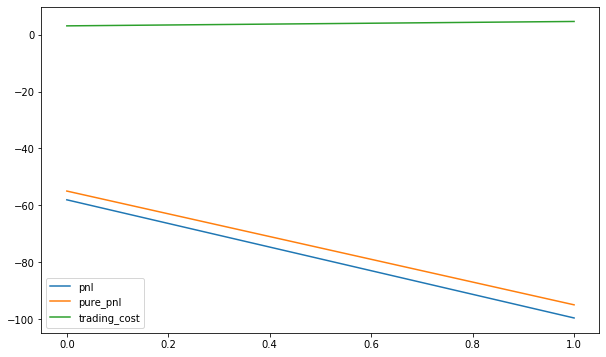

-99.6225

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()
plt.show()
np.array(pnl).sum()

In [ ]:
import statsmodels.api as sm
import datetime
holding = False
direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []
trading_date_in = ""

pure_pnl = []
trading_cost = []
pnl = []

cost_rate = 0.5 / 10000
delta_days = 8
K = 0
beta = 0
up_threshold = 0
# data_all['trading_date']  =  pd.to_datetime(data_all['trading_date']) #处理交易日时刻
#取最近5天数据
for date_index in range(0,len(pd_date_list) - delta_days):

    #根据日期获取拟合数据
    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]
    #使用数据的成交价拟合beta
    model = sm.OLS(data.last_A, data.last_B).fit()
    beta = model.params['last_B']
    eps = data.last_A - data.last_B * beta #生成拟合后数据

    #根据日期获取交易数据       
    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    #根据beta生产对手价的ask和bid序列
    eps2_ask = test_data.bid_A - test_data.ask_B * beta
    eps2_bid = test_data.ask_A - test_data.bid_B * beta
    #生成实际的成交的ask和bid价格（由于实际交易都是1:1）
    Spread2_ask = test_data.bid_A - test_data.ask_B
    Spread2_bid = test_data.ask_A - test_data.bid_B

    print(" ")
    print('test_day:',start_time)
    print(model.params)

    #进入交易
    #生成交易信号阈值
    K = 1
    if up_threshold == 0:
        up_threshold =  np.std(eps)
    else:
        up_threshold = (up_threshold * 0.7) +  (K * np.std(eps) * 0.3)
    # up_threshold = 20
    down_threshold = - up_threshold

    #生成止损信号阈值
    up_threshold_stop = np.std(eps) * 100
    down_threshold_stop = -up_threshold_stop
    #生成最大亏损信号阈值
    biggest_lost = -1000

    #生成平仓信号阈值
    up_close_threshold = up_threshold/2
    down_close_threshold = down_threshold/2

    print('beta:',beta)
    print('阈值：',up_threshold)
    print('止损点：',up_threshold_stop)

    #遍历数据判断交易
    for i, v in enumerate(eps2_ask.values):
        #交易时间点判断:去除开盘前10分钟和收盘前十分钟
        start_time1 = datetime.time(21,10,0) #夜盘开盘
        start_time2 = datetime.time(9,10,0) #早上开盘

        end_time1 = datetime.time(0,50,0) #夜盘收盘
        end_time2 = datetime.time(14,50,0) #下午收盘
        #判断是否在我们规定交易时段
        if (eps2_ask.index[i].time() > start_time1 or eps2_ask.index[i].time() < end_time1) or \
            (eps2_ask.index[i].time() > start_time2 and eps2_ask.index[i].time() < end_time2):

            ask_price = eps2_ask[i] #获取价格
            bid_price = eps2_bid[i]
            if not holding:
                # 判断进场条件
                if ask_price > up_threshold and stop_event != 'up_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'b-a'
                    trading_date_in = test_data.trading_date[i]
                    print(test_data.index[i],'b-a进场', Spread2_ask[i], ask_price,'--',len(enter_record))
                    #记录进出场信息
                    enter_record.append((Spread2_ask[i], ask_price,test_data.index[i],direction))
                elif bid_price < down_threshold and stop_event != 'down_stop':
                    holding = True
                    stop_event = "none"
                    direction = 'a-b'
                    trading_date_in = test_data.trading_date[i]
                    print(test_data.index[i],'a-b进场', Spread2_bid[i], bid_price,'--',len(enter_record))
                    enter_record.append((Spread2_bid[i], bid_price,test_data.index[i],direction))
                    
            elif holding:
                # 判断离场条件
                if direction == 'a-b' and ask_price > down_close_threshold:
                    holding = False
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append((Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                    print(test_data.index[i],'a-b出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price < up_close_threshold:
                    holding = False
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2       
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append((Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                    print(test_data.index[i],'b-a出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)

                #判断止损条件
                elif direction == 'a-b' and ask_price < down_threshold_stop:
                    holding = False
                    stop_event = 'down_stop'               
                    out_price = Spread2_ask[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (out_price - last_enter_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 

                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                    print(test_data.index[i],'a-b止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                    
                    
                elif direction =='b-a' and bid_price > up_threshold_stop:
                    holding = False
                    stop_event = 'up_stop'
                    out_price = Spread2_bid[i]
                    last_enter_price = enter_record[-1][0]
                    single_ret = (last_enter_price - out_price)
                    if trading_date_in == test_data.trading_date[i]:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                    else:
                        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2        
                    
                    pure_pnl.append(single_ret)
                    trading_cost.append(single_cost)
                    pnl.append(single_ret - single_cost)

                    print(test_data.index[i],'b-a止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                    out_record.append(( Spread2_bid[i], bid_price,test_data.index[i],single_ret,single_cost))
                else: #判断最大亏损有没有达到阈值
                    if direction == 'a-b':
                        out_price = Spread2_ask[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (out_price - last_enter_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'down_stop'
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            print(test_data.index[i],'a-b收益止损出场', Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)
                            out_record.append(( Spread2_ask[i], ask_price,test_data.index[i],single_ret,single_cost))
                    elif direction =='b-a':
                        out_price = Spread2_bid[i]
                        last_enter_price = enter_record[-1][0]
                        single_ret = (last_enter_price - out_price)
                        if single_ret < biggest_lost:
                            holding = False
                            stop_event = 'up_stop'
                            if trading_date_in == test_data.trading_date[i]:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
                            else:
                                single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2         
                            pure_pnl.append(single_ret)
                            trading_cost.append(single_cost)
                            pnl.append(single_ret - single_cost)

                            print(test_data.index[i],'b-a收益止损出场', Spread2_bid[i], bid_price,'ret:',single_ret - single_cost)
                            out_record.append((Spread2_bid[i], bid_price, test_data.index[i],single_ret,single_cost))

            
if holding:
    if direction == 'a-b':
        single_ret = (Spread2_ask[-1] - enter_record[-1][0])
    else:
        single_ret = (enter_record[-1][0] - Spread2_bid[-1])
    
    if trading_date_in == test_data.trading_date[i]:
        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i])
    else:
        single_cost = cost_rate * (test_data.last_A[i] + test_data.last_B[i]) * 2 
    pure_pnl.append(single_ret)
    trading_cost.append(single_cost)
    pnl.append(single_ret - single_cost)

    out_record.append((Spread2_ask[i], ask_price, test_data.index[i],single_ret,single_cost))
    print('还有持仓，强平',Spread2_ask[i], ask_price,'ret:',single_ret - single_cost)

#做汇总处理，生成交易日志和结果。
df_record = pd.DataFrame()
index_list = []
direction_list = []
in_out_price = []
in_out_eps_price = []
ret_list = []
cost_list = []
pure_ret_list = []
for j in range(0,len(enter_record)):
    #更新index
    index_list.append(enter_record[j][2])
    index_list.append(out_record[j][2])
    #更新方向：
    direction_list.append(enter_record[j][3] + ' in')
    direction_list.append(enter_record[j][3] + ' out')
    #更新进出场价格-原始和eps
    in_out_price.append(enter_record[j][0])
    in_out_price.append(out_record[j][0])

    in_out_eps_price.append(enter_record[j][1])
    in_out_eps_price.append(out_record[j][1])

    #更新成本和收益
    pure_ret_list.append(0) #进场为0
    pure_ret_list.append(out_record[j][3]) #出场记录

    cost_list.append(0) #进场为0
    cost_list.append(out_record[j][4]) #出场记录

    ret_list.append(0) #进场为0
    ret_list.append(out_record[j][3] - out_record[j][4]) #出场记录

#转换为datafram
df_record = data_all.loc[index_list]
df_record['trading_direction'] = direction_list
df_record['in_out_price'] = in_out_price
df_record['in_out_eps_price'] = in_out_eps_price
df_record['pure_return'] = ret_list
df_record['trading cost'] = cost_list
df_record['final return'] = pure_ret_list


In [ ]:
import datetime
start_date = datetime.datetime(2021, 1, 10)
end_date = datetime.datetime(2021, 2, 28)
data_all = audata.loc[audata.trading_date >= start_date]
data_all = data_all.loc[data_all.trading_date < end_date]

#删除为0的行，排除涨跌停导致价格为0
data_all.drop( index = data_all.ask_A[data_all.ask_A == 0].index,inplace = True)
data_all.drop( index = data_all.bid_A[data_all.bid_A == 0].index,inplace = True)
data_all.drop( index = data_all.ask_B[data_all.ask_B == 0].index,inplace = True)
data_all.drop( index = data_all.bid_B[data_all.bid_B == 0].index,inplace = True)

#获取到交易日，后面根据交易日做循环
pd_date_list = pd.DataFrame()
pd_date_list['time_stamp'] = data_all['trading_date']
# normalize, count values, convert to dataframe
pd_date_list = pd_date_list['time_stamp'].dt.normalize().value_counts().to_frame().reset_index()
# rename columns
pd_date_list.columns = ['time_stamp', 'count']
pd_date_list.sort_values(by='time_stamp',inplace=True)
pd_date_list = pd_date_list.reset_index()
pd_date_list.drop(columns='index',inplace=True)
pd_date_list


In [ ]:
import statsmodels.api as sm
import datetime
holding = False
direction = None  # "a-b", "b-a"
stop_event = "none"
enter_record = []
out_record = []
trading_date_in = ""

pure_pnl = []
trading_cost = []
pnl = []
cost_rate = 0.5 / 10000
delta_days = 5
K = 0
beta = 0
df_data_after_beta = pd.DataFrame()
#取最近5天数据
for date_index in range(0,len(pd_date_list) - delta_days):

    #根据日期获取拟合数据
    start_time = pd_date_list['time_stamp'].iloc[date_index]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]
    #使用数据的成交价拟合beta
    model = sm.OLS(data.last_A, data.last_B).fit()
    beta = model.params['last_B']
    eps = data.last_A - data.last_B * beta #生成拟合后数据

    #根据日期获取交易数据       
    start_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]
    end_time = pd_date_list['time_stamp'].iloc[date_index + delta_days]  + pd.Timedelta("1 day")
    test_data = data_all[(data_all['trading_date'] >= start_time) & (data_all['trading_date'] < end_time)]

    #根据beta生产对手价的ask和bid序列
    eps2_ask = test_data.bid_A - test_data.ask_B * beta
    eps2_bid = test_data.ask_A - test_data.bid_B * beta
    eps2_last = test_data.last_A - test_data.last_B * beta
    df_data_after_beta = pd.concat([df_data_after_beta,eps2_last])
    print(np.std(eps2_last))

    

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(np.array(pnl).cumsum(), label='pnl')
plt.plot(np.array(pure_pnl).cumsum(), label='pure_pnl')
plt.plot(np.array(trading_cost).cumsum(), label='trading_cost')
plt.legend()
plt.show()
np.array(pnl).sum()

In [ ]:
df_data_after_beta

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(df_data_after_beta,'.', label='spred')
plt.plot(data_all["spd_last"],'.', label='real')
plt.legend()
plt.show()

In [ ]:
df_record